# OpenEO service example

This notebook contains an overview of the different steps that can be taken to create and execute an OpenEO based service. It starts with the creation of an OpenEO process graph which will be shared through OpenEO's User Defined Processes (https://open-eo.github.io/openeo-python-client/udp.html). As a next step, this notebook will demonstrate how a user is able to execute these processes and combine them with additional steps using the OpenEO development tools.

## Service creation
The first part focusses on the creation of an OpenEO based processing graph that will be stored as User Defined Process (UDP). In this notebook we will create a process that generates a taskmap for a given area of interest based on an Sentinel 2 image.

### Service description
Within a taskmap, each image pixel will be assigned a specific category. These categories represents a deviation of the pixel value to the mean pixel value. These taskmaps can be used to apply precision agriculture pratices by apply different fertilizing strategies for each category. For example - a farmer can decide to apply more product on parts of the field that have a negative deviation and less on positive deviations (making worse areas better) or apply more products on positive deviations (focus on good areas of the field). An example of such a taskmap is shown in the image below

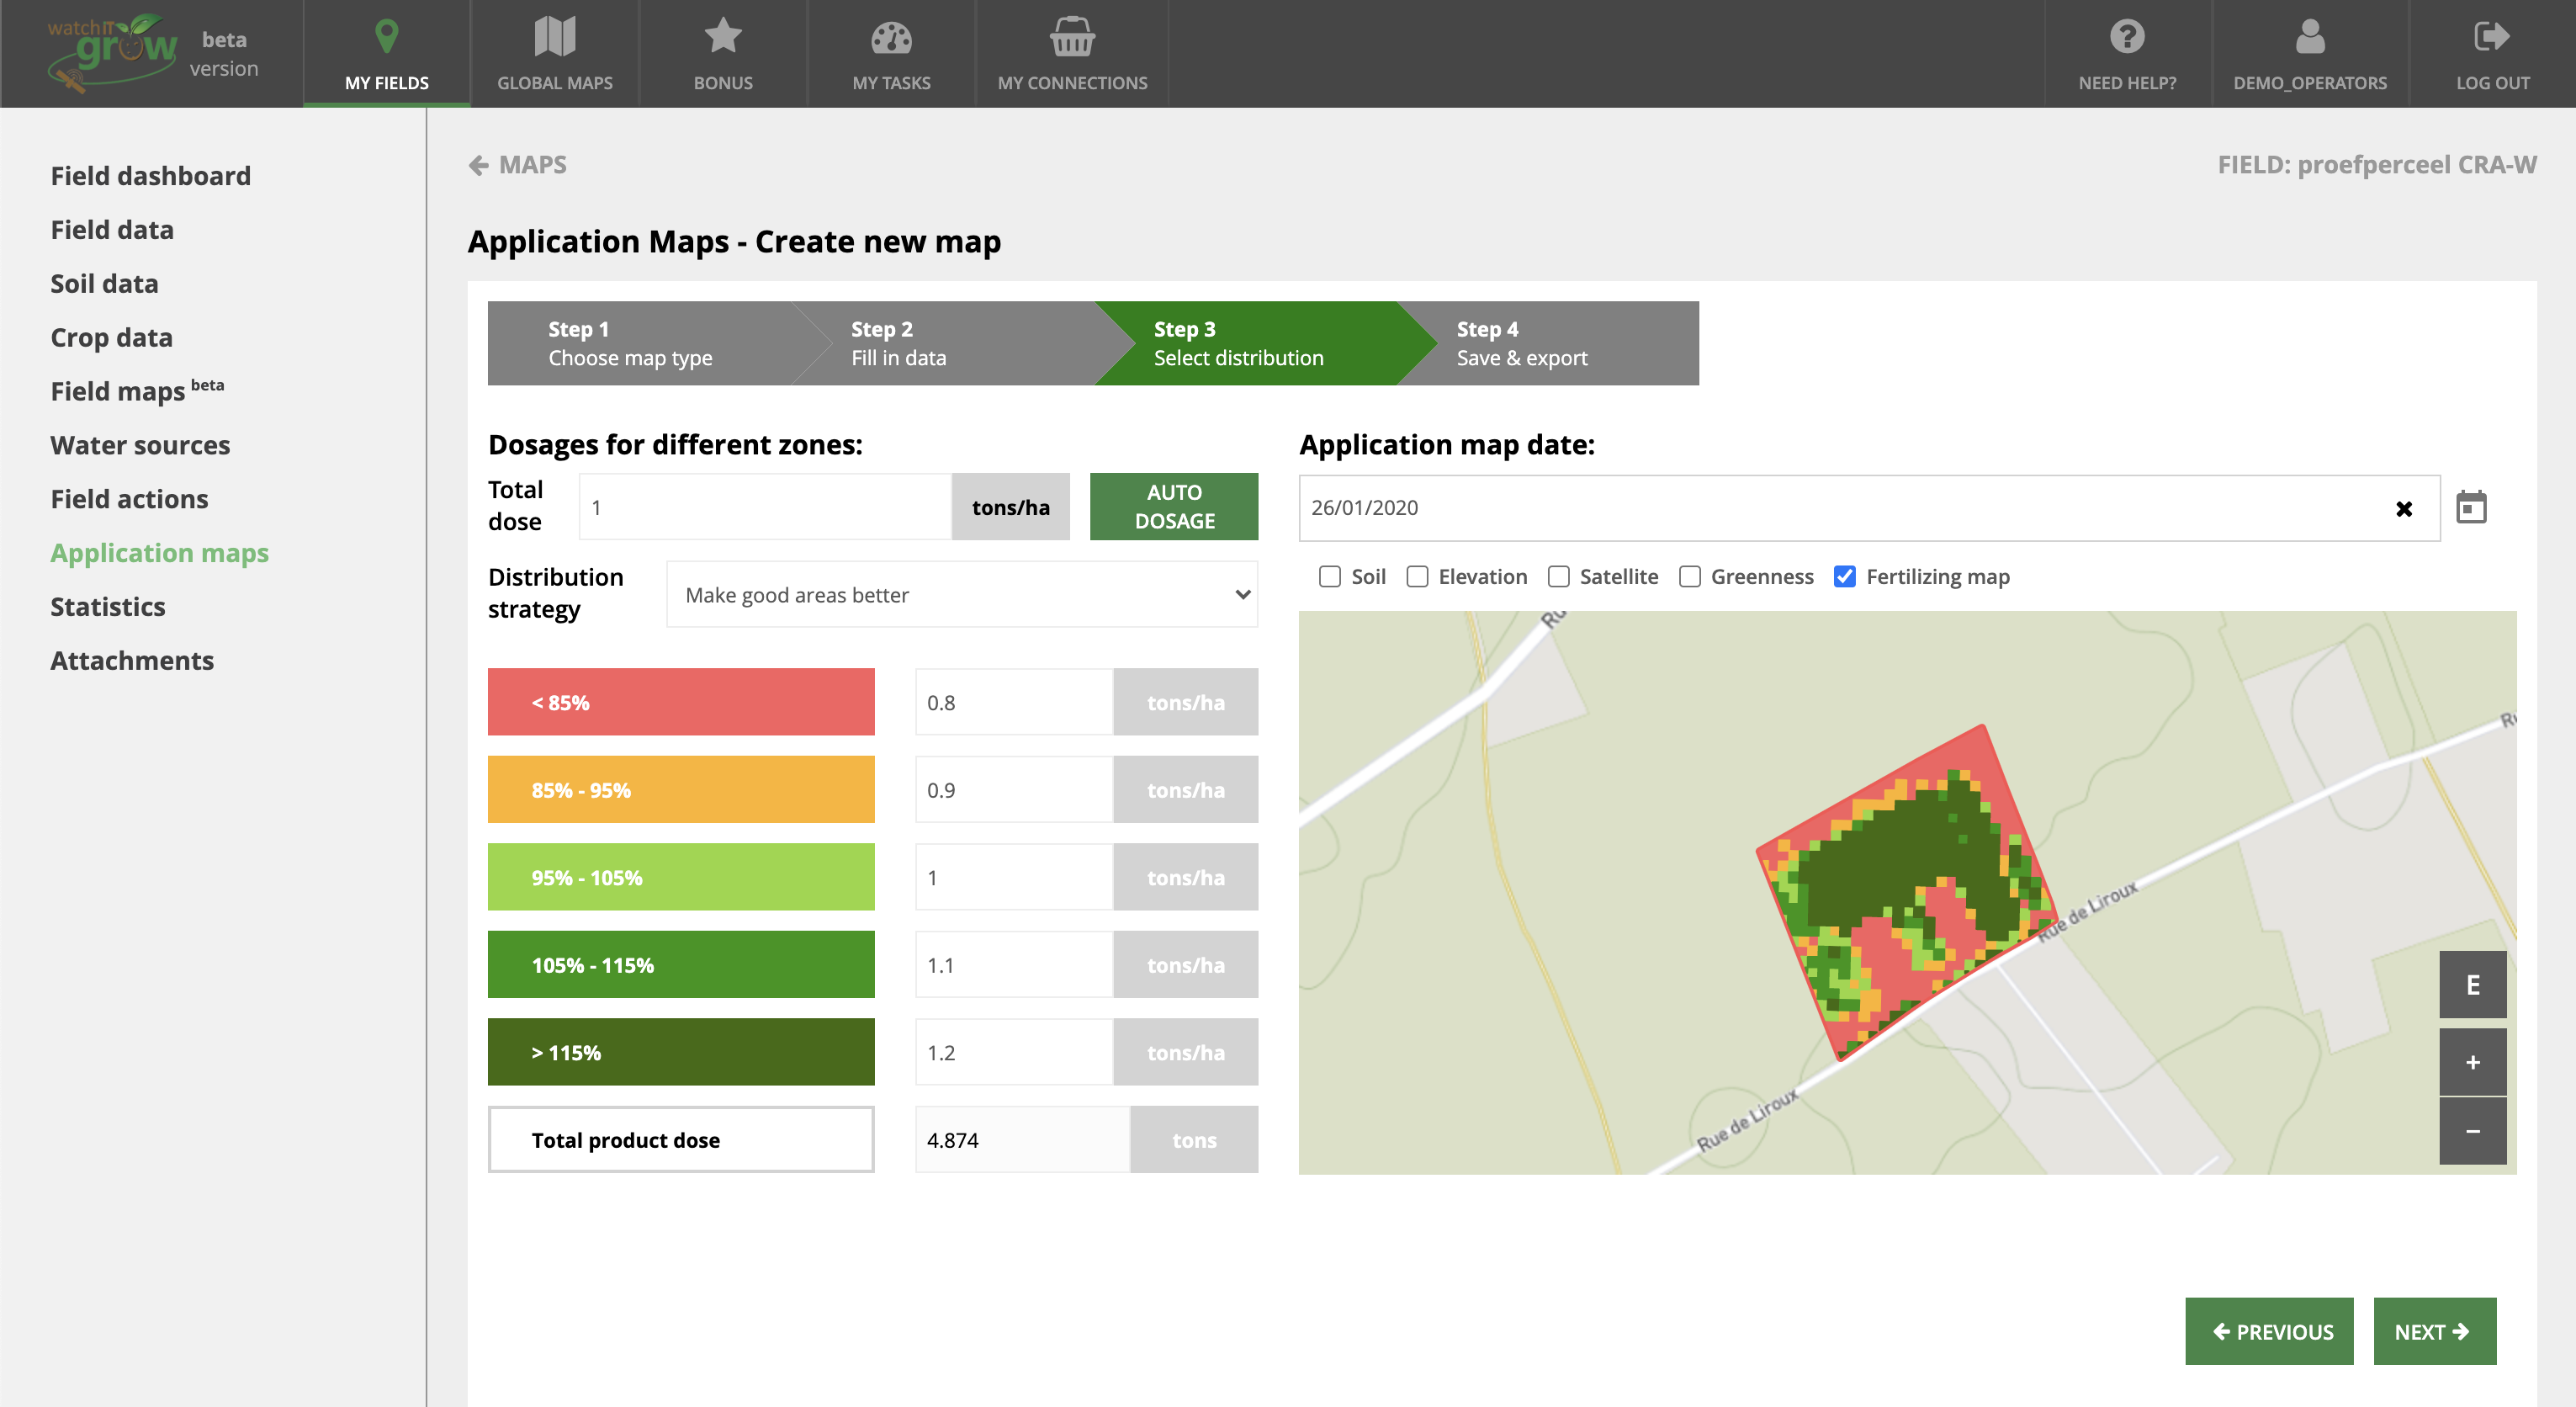

### Parameters
Before we start with the actual implementation details, we set up the parameters used for calculating the taskmap. In this example, a random field has been selected together with a date for which a cloudfree satellite image is available. The map below visualizes the field and the corresponding satellite image that will be used to generate the taskmap.

In [2]:
from shapely.geometry import Polygon

In [3]:
aoi = {
        "type": "Polygon",
        "coordinates": [
          [
            [
              5.179324150085449,
              51.2498689148547
            ],
            [
              5.178744792938232,
              51.24672597710759
            ],
            [
              5.185289382934569,
              51.24504696935156
            ],
            [
              5.18676996231079,
              51.245342479161295
            ],
            [
              5.187370777130127,
              51.24918393390799
            ],
            [
              5.179324150085449,
              51.2498689148547
            ]
          ]
        ]
      }
aoi_poly = Polygon(aoi["coordinates"][0])
aoi_bounds = {
    "west": aoi_poly.bounds[0], "east": aoi_poly.bounds[2],
    "south": aoi_poly.bounds[1], "north": aoi_poly.bounds[3],
    "crs": "EPSG:4326"
    }

date = '2020-06-01'

In [5]:
from ipyleaflet import Map, GeoJSON, WMSLayer, ImageOverlay
from traitlets import Unicode 

class TimeWMSLayer(WMSLayer):
    time = Unicode('').tag(sync=True, o=True)

aoi_layer = GeoJSON(
    data=aoi
)

color_layer = TimeWMSLayer(
    url='https://services.terrascope.be/wms/v2',
    layers='CGS_S2_RADIOMETRY',
    format='image/png',
    transparent=True,
    time=date
)

m = Map(center=(51.24784080439523, 5.183165073394775),zoom=15)

m.add_layer(aoi_layer);
m.add_layer(color_layer);
m

Map(center=[51.24784080439523, 5.183165073394775], controls=(ZoomControl(options=['position', 'zoom_in_text', …

### OpenEO implementation
The next paragraph contains the development of the taskmap within OpenEO. Next cells contain an overview of the different functions to setup the OpenEO processing graph. As a last step, the resulting graph will be published to OpenEO User Defined Processes.

In [6]:
!pip install openeo==0.4.9 --user
import openeo
from openeo.api.process import Parameter
import json
import os
import rasterio
from rasterio.plot import show

Looking in indexes: https://artifactory.vgt.vito.be/api/pypi/python-packages/simple
You should consider upgrading via the 'pip install --upgrade pip' command.


We start by setting up an authenticated connection to OpenEO

In [7]:
backend_url = "https://openeo.vito.be/openeo/1.0/"
con = openeo.connect(backend_url).authenticate_basic('bram', 'bram123')

Next we setup a set of fixed parameters that will be exposed for executing the workflow

In [8]:
aoi_bounds_param =  Parameter(
    name="bbox",
    schema="object",
    description="Bounding box to cut out"
)

date_param =  Parameter(
    name="date",
    description="Temporal extent for the taskmap input",
    schema="string"
)

A function is setup to load in the user defined function required to calculate the taskmap (More information on https://open-eo.github.io/openeo-python-client/udf.html)

In [9]:
def load_udf(path):
    with open(path, 'r+') as f:
        return f.read()

Next we start creating the processing graph based on processes available within the OpenEO backend system (https://openeo.org/documentation/1.0/processes.html)

In [10]:
# Get the required data collection
taskmap_dc = con.load_collection("TERRASCOPE_S2_FAPAR_V2", bands=["FAPAR_10M"], spatial_extent=aoi_bounds_param)
taskmap_dc = taskmap_dc.filter_temporal(date_param, date_param)
taskmap_dc = taskmap_dc.mask_polygon(aoi_poly)

# Calculation of the taskmap
calculate_udf = load_udf('./udf.py')
taskmap_dc = taskmap_dc.reduce_temporal_udf(calculate_udf)

print(json.dumps(taskmap_dc.graph, indent=4))

{
    "loadcollection1": {
        "process_id": "load_collection",
        "arguments": {
            "bands": [
                "FAPAR_10M"
            ],
            "id": "TERRASCOPE_S2_FAPAR_V2",
            "spatial_extent": {
                "from_parameter": "bbox"
            },
            "temporal_extent": null
        }
    },
    "filtertemporal1": {
        "process_id": "filter_temporal",
        "arguments": {
            "data": {
                "from_node": "loadcollection1"
            },
            "extent": [
                {
                    "from_parameter": "date"
                },
                {
                    "from_parameter": "date"
                }
            ]
        }
    },
    "maskpolygon1": {
        "process_id": "mask_polygon",
        "arguments": {
            "data": {
                "from_node": "filtertemporal1"
            },
            "mask": {
                "type": "Polygon",
                "coordinates": [
          

We can now save the processing graph as a user defined process to re-use in other workflows

In [11]:
con.save_user_defined_process(
    user_defined_process_id='taskmap_calculate',
    process_graph=taskmap_dc.graph,
    parameters=[aoi_bounds_param, date_param]
   
)

## Service execution
The service for generating the taskmap has now been saved to the *taskmap_calculate* service stored in the users' UDP list. We can use the existing OpenEO processes to create a new processing graph based on these existing services.

### List available services

In [12]:
con.list_user_defined_processes()

[{'id': 'taskmap_calculate',
  'parameters': [{'description': 'Bounding box to cut out',
    'name': 'bbox',
    'schema': {'type': 'object'}},
   {'description': 'Temporal extent for the taskmap input',
    'name': 'date',
    'schema': {'type': 'string'}}],
  'public': False}]

### Create process graph from existing services
As a next step we will create a new processing graph that will use the existing *taskmap_calculate* service and combine this with additional step to mask the initial field.

In [13]:
# Create a datacube from an existing process 
taskmap = con.datacube_from_process("taskmap_calculate", bbox=aoi_bounds, date=date)

# Add a custom step to cut out the polygon
taskmap = taskmap.mask_polygon(aoi_poly)

print(json.dumps(taskmap.graph, indent=4))

{
    "taskmapcalculate1": {
        "process_id": "taskmap_calculate",
        "arguments": {
            "bbox": {
                "west": 5.178744792938232,
                "east": 5.187370777130127,
                "south": 51.24504696935156,
                "north": 51.2498689148547,
                "crs": "EPSG:4326"
            },
            "date": "2020-06-01"
        }
    },
    "maskpolygon1": {
        "process_id": "mask_polygon",
        "arguments": {
            "data": {
                "from_node": "taskmapcalculate1"
            },
            "mask": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [
                            5.179324150085449,
                            51.2498689148547
                        ],
                        [
                            5.178744792938232,
                            51.24672597710759
                        ],
                        [
            

/home/bramjanssen/.local/lib/python3.6/site-packages/openeo/metadata.py:219: UserWarning: No cube:dimensions metadata
  complain("No cube:dimensions metadata")


### Execute processing graph as synchronous request

In [14]:
import rasterio
from rasterio.plot import show

def show_result(file):
    img = rasterio.open(file)
    show(img)

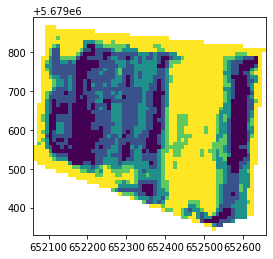

In [18]:
taskmap_downloaded = taskmap.download('taskmap_sync.tiff', format='gtiff')
show_result('taskmap_sync.tiff')

### Execute processing graph
Once we have created the processing graph to execute, we can send it to the backend for processing. In this example we are creating a job that executes the service on the MEP infrastructure.

In [ ]:
taskmap_job = taskmap.save_result(format='gtiff')
job = taskmap_job.send_job()
res = job.start_and_wait().download_results('.')
os.rename('./out', 'taskmap_job.tiff')
show_result('taskmap_job.tiff')